In [1]:
# 动作识别系统 - NTU RGB+D + MediaPipe + LSTM
# 
# 项目概述:
# 1. 使用NTU RGB+D数据集的skeleton文件训练LSTM模型
# 2. 使用MediaPipe实时提取骨骼关键点
# 3. 实现端到端的动作识别系统

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import mediapipe as mp
import os
import pickle
import json
from collections import deque
import warnings
warnings.filterwarnings('ignore')

print("导入库完成!")
print(f"TensorFlow版本: {tf.__version__}")
print("系统初始化完成!")

导入库完成!
TensorFlow版本: 2.17.0
系统初始化完成!


In [2]:
# 数据集路径设置（如需修改请直接改这里）
DATA_PATHS = [
    r"F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D0-30000",
    r"F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D30001-56880"
 ]
print("DATA_PATHS 已设置:", DATA_PATHS)

DATA_PATHS 已设置: ['F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D0-30000', 'F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D30001-56880']


# NTU RGB+D 动作识别系统

## 项目目标
使用NTU RGB+D数据集训练LSTM模型，结合MediaPipe实现实时动作识别

## 系统架构
1. **数据预处理**: NTU RGB+D skeleton数据处理
2. **关节点映射**: NTU(25关节) → MediaPipe(33关节)映射
3. **LSTM模型**: 时序动作识别
4. **实时识别**: MediaPipe + 训练模型

## 数据集信息
- NTU RGB+D: 25个3D关节点
- MediaPipe Pose: 33个2D/3D关节点
- 需要关节点标准化和映射

In [3]:
# 1. NTU RGB+D 数据集处理类
class NTUDataProcessor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.actions = {}  # 动作标签映射
        self.sequences = []  # 骨骼序列数据
        self.labels = []     # 对应标签
        
        # NTU RGB+D 25个关节点定义
        self.ntu_joints = {
            0: 'spine_base', 1: 'spine_mid', 2: 'neck', 3: 'head',
            4: 'shoulder_left', 5: 'elbow_left', 6: 'wrist_left', 7: 'hand_left',
            8: 'shoulder_right', 9: 'elbow_right', 10: 'wrist_right', 11: 'hand_right',
            12: 'hip_left', 13: 'knee_left', 14: 'ankle_left', 15: 'foot_left',
            16: 'hip_right', 17: 'knee_right', 18: 'ankle_right', 19: 'foot_right',
            20: 'spine_shoulder', 21: 'hand_tip_left', 22: 'thumb_left',
            23: 'hand_tip_right', 24: 'thumb_right'
        }
    
    def parse_skeleton_file(self, file_path):
        """解析NTU RGB+D的skeleton文件"""
        with open(file_path, 'r') as f:
            frame_count = int(f.readline())
            sequence = []
            
            for frame in range(frame_count):
                body_count = int(f.readline())
                frame_data = []
                
                for body in range(body_count):
                    # 读取body info
                    body_info = f.readline()
                    joint_count = int(f.readline())
                    
                    joints = []
                    for joint in range(joint_count):
                        joint_data = list(map(float, f.readline().split()))
                        # joint_data: [x, y, z, depth_x, depth_y, color_x, color_y, orient_w, orient_x, orient_y, orient_z, tracking_state]
                        # 我们主要使用前3个坐标: x, y, z
                        joints.append([joint_data[0], joint_data[1], joint_data[2]])
                    
                    if len(joints) == 25:  # 确保有25个关节点
                        frame_data.append(joints)
                
                if frame_data:  # 如果有有效的body数据
                    sequence.append(frame_data[0])  # 取第一个人的数据
            
            return np.array(sequence) if sequence else None
    
    def extract_action_label(self, filename):
        """从文件名提取动作标签"""
        # NTU文件名格式: SsssCcccPpppRrrrAaaa.skeleton
        # A后面的三位数字是动作编号
        action_id = int(filename[17:20])
        return action_id
    
    def load_dataset(self, max_files=None):
        """加载数据集"""
        skeleton_files = [f for f in os.listdir(self.data_path) if f.endswith('.skeleton')]
        
        if max_files:
            skeleton_files = skeleton_files[:max_files]
        
        print(f"找到 {len(skeleton_files)} 个skeleton文件")
        
        for i, filename in enumerate(skeleton_files):
            file_path = os.path.join(self.data_path, filename)
            sequence = self.parse_skeleton_file(file_path)
            
            if sequence is not None and len(sequence) > 0:
                action_label = self.extract_action_label(filename)
                self.sequences.append(sequence)
                self.labels.append(action_label)
            
            if (i + 1) % 100 == 0:
                print(f"已处理 {i + 1} 个文件...")
        
        print(f"成功加载 {len(self.sequences)} 个序列")
        return np.array(self.sequences, dtype=object), np.array(self.labels)

# 初始化数据处理器
# data_processor = NTUDataProcessor("你的NTU数据集路径")
print("NTU数据处理类定义完成!")

NTU数据处理类定义完成!


In [4]:
# 2. NTU到MediaPipe关节点映射
class JointMapper:
    def __init__(self):
        # NTU RGB+D (25关节) 到 MediaPipe Pose (33关节) 的映射
        self.ntu_to_mediapipe = {
            # 头部和颈部
            3: 0,   # head -> nose
            2: 11,  # neck -> left_shoulder (近似)
            2: 12,  # neck -> right_shoulder (近似)
            
            # 上半身
            20: 11, # spine_shoulder -> left_shoulder (近似)
            20: 12, # spine_shoulder -> right_shoulder (近似)
            4: 11,  # shoulder_left -> left_shoulder
            8: 12,  # shoulder_right -> right_shoulder
            5: 13,  # elbow_left -> left_elbow
            9: 14,  # elbow_right -> right_elbow
            6: 15,  # wrist_left -> left_wrist
            10: 16, # wrist_right -> right_wrist
            7: 17,  # hand_left -> left_pinky (近似)
            11: 18, # hand_right -> right_pinky (近似)
            
            # 下半身
            0: 23,  # spine_base -> left_hip (近似)
            0: 24,  # spine_base -> right_hip (近似)
            12: 23, # hip_left -> left_hip
            16: 24, # hip_right -> right_hip
            13: 25, # knee_left -> left_knee
            17: 26, # knee_right -> right_knee
            14: 27, # ankle_left -> left_ankle
            18: 28, # ankle_right -> right_ankle
            15: 31, # foot_left -> left_foot_index
            19: 32, # foot_right -> right_foot_index
        }
        
        # MediaPipe关节点名称
        self.mediapipe_joints = [
            'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer',
            'right_eye_inner', 'right_eye', 'right_eye_outer',
            'left_ear', 'right_ear', 'mouth_left', 'mouth_right',
            'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
            'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky',
            'left_index', 'right_index', 'left_thumb', 'right_thumb',
            'left_hip', 'right_hip', 'left_knee', 'right_knee',
            'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
            'left_foot_index', 'right_foot_index'
        ]
    
    def ntu_to_mediapipe_format(self, ntu_sequence):
        """将NTU格式转换为MediaPipe格式"""
        mediapipe_sequence = []
        
        for frame in ntu_sequence:
            mp_frame = np.zeros((33, 3))  # 33个关节点，3个坐标
            
            # 直接映射能对应的关节点
            for ntu_idx, mp_idx in self.ntu_to_mediapipe.items():
                if ntu_idx < len(frame):
                    mp_frame[mp_idx] = frame[ntu_idx]
            
            # 对于没有直接对应的关节点，可以通过插值或设为0
            # 这里简化处理，设为0或使用相邻关节点的平均值
            
            mediapipe_sequence.append(mp_frame)
        
        return np.array(mediapipe_sequence)
    
    def normalize_coordinates(self, sequence):
        """标准化坐标"""
        if len(sequence) == 0:
            return sequence
            
        # 以第一帧的中心点（脊柱中点）为原点进行标准化
        center_joint_idx = 1  # spine_mid
        
        normalized_sequence = []
        for frame in sequence:
            if len(frame) > center_joint_idx:
                center = frame[center_joint_idx]
                normalized_frame = frame - center
                normalized_sequence.append(normalized_frame)
            else:
                normalized_sequence.append(frame)
        
        return np.array(normalized_sequence)

joint_mapper = JointMapper()
print("关节点映射器初始化完成!")

关节点映射器初始化完成!


In [ ]:
class ActionRecognitionLSTM:
    def __init__(self, sequence_length=30, num_joints=25, num_classes=60):
        self.sequence_length = sequence_length
        self.num_joints = num_joints
        self.num_classes = num_classes
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()

    def create_model(self, use_optimized=False, optimizer='adam', learning_rate=0.001):
        """创建LSTM模型，use_optimized=True时采用Conv1D+双向LSTM结构，支持自定义优化器"""
        from tensorflow.keras.layers import Conv1D, Bidirectional
        # 优化器处理
        if isinstance(optimizer, str):
            if optimizer.lower() == 'adam':
                opt = Adam(learning_rate=learning_rate)
            elif optimizer.lower() == 'sgd':
                opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
            elif optimizer.lower() == 'rmsprop':
                opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            else:
                opt = Adam(learning_rate=learning_rate)
        else:
            opt = optimizer
        if use_optimized:
            model = Sequential([
                Conv1D(64, kernel_size=3, activation='relu', input_shape=(self.sequence_length, self.num_joints * 3)),
                BatchNormalization(),
                Dropout(0.3),
                Bidirectional(LSTM(128, return_sequences=True)),
                BatchNormalization(),
                Dropout(0.3),
                Bidirectional(LSTM(64, return_sequences=False)),
                BatchNormalization(),
                Dropout(0.3),
                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),
                Dense(self.num_classes, activation='softmax')
            ])
        else:
            model = Sequential([
                LSTM(128, return_sequences=True, 
                     input_shape=(self.sequence_length, self.num_joints * 3)),
                BatchNormalization(),
                Dropout(0.3),
                LSTM(64, return_sequences=True),
                BatchNormalization(),
                Dropout(0.3),
                LSTM(32, return_sequences=False),
                BatchNormalization(),
                Dropout(0.3),
                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(0.3),
                Dense(self.num_classes, activation='softmax')
            ])
        model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model = model
        return model

    def prepare_sequences(self, sequences, labels):
        X, y = [], []
        for seq, label in zip(sequences, labels):
            if len(seq) >= self.sequence_length:
                indices = np.linspace(0, len(seq)-1, self.sequence_length, dtype=int)
                seq = seq[indices]
            else:
                pad_length = self.sequence_length - len(seq)
                last_frame = seq[-1:] if len(seq) > 0 else np.zeros((1, self.num_joints, 3))
                padding = np.repeat(last_frame, pad_length, axis=0)
                seq = np.concatenate([seq, padding], axis=0)
            seq_flattened = seq.reshape(self.sequence_length, -1)
            X.append(seq_flattened)
            y.append(label)
        return np.array(X), np.array(y)

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, use_optimized=False):
        if self.model is None:
            self.create_model(use_optimized=use_optimized)
        X_train_scaled = self.scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
        X_train_scaled = X_train_scaled.reshape(X_train.shape)
        X_val_scaled = self.scaler.transform(X_val.reshape(-1, X_val.shape[-1]))
        X_val_scaled = X_val_scaled.reshape(X_val.shape)
        y_train_encoded = tf.keras.utils.to_categorical(
            self.label_encoder.fit_transform(y_train), 
            num_classes=self.num_classes
        )
        y_val_encoded = tf.keras.utils.to_categorical(
            self.label_encoder.transform(y_val), 
            num_classes=self.num_classes
        )
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ModelCheckpoint('best_action_model.keras', save_best_only=True)
        ]
        history = self.model.fit(
            X_train_scaled, y_train_encoded,
            validation_data=(X_val_scaled, y_val_encoded),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        return history

    def save_model(self, model_path="action_recognition_model.keras"):
        if self.model:
            self.model.save(model_path)
            with open('scaler.pkl', 'wb') as f:
                pickle.dump(self.scaler, f)
            with open('label_encoder.pkl', 'wb') as f:
                pickle.dump(self.label_encoder, f)

    def load_model(self, model_path="action_recognition_model.keras"):
        self.model = tf.keras.models.load_model(model_path)
        with open('scaler.pkl', 'rb') as f:
            self.scaler = pickle.load(f)
        with open('label_encoder.pkl', 'rb') as f:
            self.label_encoder = pickle.load(f)

print("LSTM模型类定义完成!（已支持优化结构和自定义优化器/批次大小）")

LSTM模型类定义完成!（已支持优化结构）


In [6]:
# 4. MediaPipe实时骨骼检测
class MediaPipeDetector:
    def __init__(self):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=1,
            smooth_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils
        
    def extract_keypoints(self, image):
        """从图像提取关键点"""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image_rgb)
        
        if results.pose_landmarks:
            # 提取33个关键点的坐标
            keypoints = []
            for landmark in results.pose_landmarks.landmark:
                keypoints.append([landmark.x, landmark.y, landmark.z])
            return np.array(keypoints), results
        else:
            return None, results
    
    def draw_landmarks(self, image, results):
        """在图像上绘制关键点"""
        if results.pose_landmarks:
            self.mp_drawing.draw_landmarks(
                image, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS)
        return image
    
    def normalize_keypoints(self, keypoints):
        """标准化关键点坐标"""
        if keypoints is None:
            return None
        
        # 以左右肩膀的中点为中心进行标准化
        left_shoulder = keypoints[11]  # left_shoulder
        right_shoulder = keypoints[12]  # right_shoulder
        center = (left_shoulder + right_shoulder) / 2
        
        # 减去中心点坐标
        normalized_keypoints = keypoints - center
        
        return normalized_keypoints

mp_detector = MediaPipeDetector()
print("MediaPipe检测器初始化完成!")

MediaPipe检测器初始化完成!


In [7]:
# 5. 实时动作识别系统
class RealTimeActionRecognition:
    def __init__(self, model, sequence_length=30):
        self.model = model
        self.sequence_length = sequence_length
        self.mp_detector = MediaPipeDetector()
        self.frame_buffer = deque(maxlen=sequence_length)
        
        # NTU RGB+D 动作标签 (前20个常见动作)
        self.action_labels = {
            1: "drink water", 2: "eat meal/snack", 3: "brushing teeth",
            4: "brushing hair", 5: "drop", 6: "pickup", 7: "throw",
            8: "sitting down", 9: "standing up", 10: "clapping",
            11: "reading", 12: "writing", 13: "tear up paper",
            14: "wear jacket", 15: "take off jacket", 16: "wear a shoe",
            17: "take off a shoe", 18: "wear on glasses", 19: "take off glasses",
            20: "put on a hat/cap"
        }
    
    def preprocess_frame(self, keypoints):
        """预处理单帧数据"""
        if keypoints is None:
            return np.zeros((33, 3))
        
        # 标准化
        normalized_keypoints = self.mp_detector.normalize_keypoints(keypoints)
        return normalized_keypoints
    
    def predict_action(self):
        """预测当前动作"""
        if len(self.frame_buffer) < self.sequence_length:
            return None, 0.0
        
        # 准备输入序列
        sequence = np.array(list(self.frame_buffer))
        sequence_flattened = sequence.reshape(1, self.sequence_length, -1)
        
        # 标准化
        sequence_scaled = self.model.scaler.transform(
            sequence_flattened.reshape(-1, sequence_flattened.shape[-1])
        )
        sequence_scaled = sequence_scaled.reshape(sequence_flattened.shape)
        
        # 预测
        prediction = self.model.model.predict(sequence_scaled, verbose=0)
        predicted_class = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        # 转换为原始标签
        action_id = self.model.label_encoder.inverse_transform([predicted_class])[0]
        action_name = self.action_labels.get(action_id, f"Action {action_id}")
        
        return action_name, confidence
    
    def run_camera(self, camera_id=0):
        """运行摄像头实时识别"""
        cap = cv2.VideoCapture(camera_id)
        
        print("按 'q' 退出实时识别")
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # 镜像翻转
            frame = cv2.flip(frame, 1)
            
            # 提取关键点
            keypoints, results = self.mp_detector.extract_keypoints(frame)
            
            # 绘制关键点
            frame = self.mp_detector.draw_landmarks(frame, results)
            
            if keypoints is not None:
                # 预处理并添加到缓冲区
                processed_keypoints = self.preprocess_frame(keypoints)
                self.frame_buffer.append(processed_keypoints.flatten())
                
                # 预测动作
                action, confidence = self.predict_action()
                
                if action and confidence > 0.5:  # 置信度阈值
                    cv2.putText(frame, f"Action: {action}", (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    cv2.putText(frame, f"Confidence: {confidence:.2f}", (10, 70),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            cv2.imshow('Real-time Action Recognition', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()

print("实时动作识别系统定义完成!")

实时动作识别系统定义完成!


In [ ]:
def train_action_recognition_model(epochs=50, learning_rate=0.001, batch_size=32, optimizer='adam', load_pretrained=False, pretrained_path="ntu_action_recognition_model.keras",
                                 preprocessed_cache_path="ntu_preprocessed_cache.pkl", data_paths=None):
    """
    完整的训练流程（仅优化结构）
    参数：
        epochs: 训练轮数
        learning_rate: 学习率
        batch_size: 批次大小
        optimizer: 优化器名称或实例（如 'adam', 'sgd', tf.keras.optimizers.Adam()）
        load_pretrained: 是否加载已有模型继续训练
        pretrained_path: 已有模型路径
        preprocessed_cache_path: 预处理数据缓存路径
        data_paths: 数据集路径列表（可选，未传则自动查找全局 DATA_PATHS）
    """
    # 自动查找 DATA_PATHS
    if data_paths is None:
        try:
            data_paths = DATA_PATHS
        except NameError:
            raise RuntimeError("未传入 data_paths 且未定义全局 DATA_PATHS，请先定义数据集路径！如：DATA_PATHS = ['F:/DataSet/Raw_Skeleton_S01-S17/skeleton+D0-30000', ...]")
    # 1. 加载NTU数据集（多个文件夹）
    print("1. 加载NTU RGB+D数据集...")
    sequences, labels = load_all_datasets(data_paths, max_files=None)
    if len(sequences) == 0:
        print("未找到数据文件，请检查数据路径！")
        return None
    print(f"加载了 {len(sequences)} 个序列")
    # 2. 数据预处理（带缓存）
    print("2. 数据预处理...")
    import os, pickle
    if os.path.exists(preprocessed_cache_path):
        print(f"检测到预处理缓存 {preprocessed_cache_path}，正在加载...")
        with open(preprocessed_cache_path, 'rb') as f:
            cache = pickle.load(f)
        processed_sequences = cache['processed_sequences']
        labels = cache['labels']
        print(f"预处理数据加载完成，包含 {len(processed_sequences)} 个序列。")
    else:
        processed_sequences = []
        for seq in sequences:
            normalized_seq = joint_mapper.normalize_coordinates(seq)
            processed_sequences.append(normalized_seq)
        with open(preprocessed_cache_path, 'wb') as f:
            pickle.dump({'processed_sequences': processed_sequences, 'labels': labels}, f)
        print(f"已将预处理数据缓存到 {preprocessed_cache_path}")
    # 3. 创建LSTM模型（仅优化结构）
    print("3. 创建优化结构LSTM模型...")
    model = ActionRecognitionLSTM(
        sequence_length=30,
        num_joints=25,  # NTU RGB+D有25个关节点
        num_classes=len(np.unique(labels))
    )
    # 4. 准备训练数据
    print("4. 准备训练数据...")
    X, y = model.prepare_sequences(processed_sequences, labels)
    print("X shape:", X.shape, "y shape:", y.shape, "类别数:", len(np.unique(y)))
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"训练集大小: {len(X_train)}")
    print(f"验证集大小: {len(X_val)}")
    # 5. 加载已有模型或新建模型
    if load_pretrained and os.path.exists(pretrained_path):
        print(f"加载已有模型: {pretrained_path}")
        model.load_model(pretrained_path)
        # 重新设置学习率
        if hasattr(model.model.optimizer.learning_rate, "assign"):
            model.model.optimizer.learning_rate.assign(learning_rate)
        else:
            model.model.optimizer.learning_rate = learning_rate
    else:
        print("新建模型并设置学习率和优化器")
        model.create_model(use_optimized=True, optimizer=optimizer, learning_rate=learning_rate)
    # 6. 训练模型（仅优化结构）
    print("6. 开始训练优化结构模型...")
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, use_optimized=True)
    # 7. 保存模型
    print("7. 保存模型...")
    model.save_model(pretrained_path)
    # 8. 绘制训练曲线
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model

print("仅优化结构的训练流程函数定义完成! 使用 train_action_recognition_model(epochs, learning_rate, batch_size, optimizer, load_pretrained) 开始训练")

仅优化结构的训练流程函数定义完成! 使用 train_action_recognition_model(epochs, learning_rate, load_pretrained) 开始训练


In [9]:
def load_all_datasets(paths, max_files=None):
    all_sequences = []
    all_labels = []
    for path in paths:
        processor = NTUDataProcessor(path)
        sequences, labels = processor.load_dataset(max_files)
        all_sequences.extend(sequences)
        all_labels.extend(labels)
    print("类别数：", len(np.unique(labels)))
    print("类别编号：", np.unique(labels))
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"类别{u}：{c}个样本")
    return np.array(all_sequences, dtype=object), np.array(all_labels)

In [10]:
# 7. 实时识别演示

def demo_real_time_recognition():
    """实时识别演示"""
    
    # 1. 加载训练好的模型
    print("加载训练好的模型...")
    model = ActionRecognitionLSTM()
    
    try:
        model.load_model("ntu_action_recognition_model.keras")
        print("模型加载成功!")
        
        # 2. 创建实时识别系统
        real_time_system = RealTimeActionRecognition(model)
        
        # 3. 开始实时识别
        print("开始实时动作识别...")
        print("请确保摄像头已连接，按 'q' 退出")
        real_time_system.run_camera(camera_id=0)
        
    except FileNotFoundError:
        print("未找到训练好的模型文件！")
        print("请先运行 train_action_recognition_model() 训练模型")


1. 加载NTU RGB+D数据集...
找到 28981 个skeleton文件
找到 28981 个skeleton文件
已处理 100 个文件...
已处理 100 个文件...
已处理 200 个文件...
已处理 200 个文件...
已处理 300 个文件...
已处理 300 个文件...
已处理 400 个文件...
已处理 400 个文件...
已处理 500 个文件...
已处理 500 个文件...
已处理 600 个文件...
已处理 600 个文件...
已处理 700 个文件...
已处理 700 个文件...
已处理 800 个文件...
已处理 800 个文件...
已处理 900 个文件...
已处理 900 个文件...
已处理 1000 个文件...
已处理 1000 个文件...
已处理 1100 个文件...
已处理 1100 个文件...
已处理 1200 个文件...
已处理 1200 个文件...
已处理 1300 个文件...
已处理 1300 个文件...
已处理 1400 个文件...
已处理 1400 个文件...
已处理 1500 个文件...
已处理 1500 个文件...
已处理 1600 个文件...
已处理 1600 个文件...
已处理 1700 个文件...
已处理 1700 个文件...
已处理 1800 个文件...
已处理 1800 个文件...
已处理 1900 个文件...
已处理 1900 个文件...
已处理 2000 个文件...
已处理 2000 个文件...
已处理 2100 个文件...
已处理 2100 个文件...
已处理 2200 个文件...
已处理 2200 个文件...
已处理 2300 个文件...
已处理 2300 个文件...
已处理 2400 个文件...
已处理 2400 个文件...
已处理 2500 个文件...
已处理 2500 个文件...
已处理 2600 个文件...
已处理 2600 个文件...
已处理 2700 个文件...
已处理 2700 个文件...
已处理 2800 个文件...
已处理 2800 个文件...
已处理 2900 个文件...
已处理 2900 个文件...
已处理 3000 个文件...
已处理 3000 个文

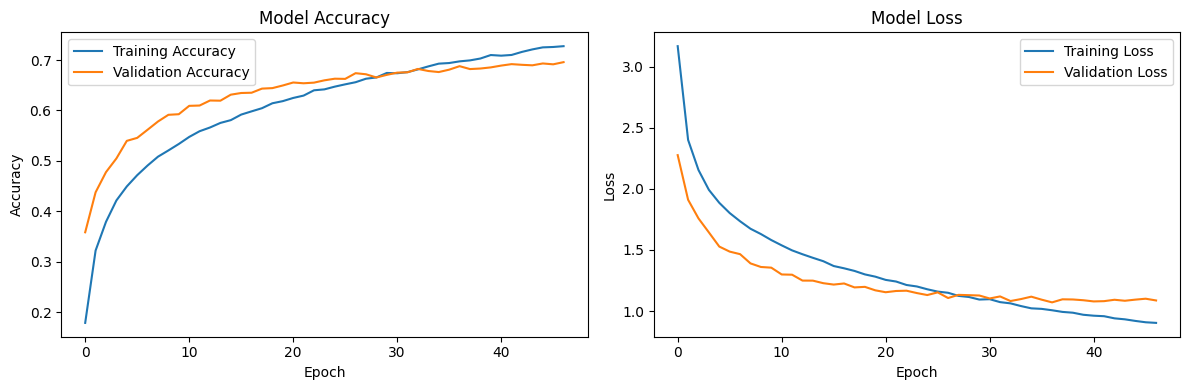

In [ ]:
train_action_recognition_model(epochs=100, learning_rate=0.0005, load_pretrained=False,batch_size=16, optimizer='RAdam')